# Variational circuits for a classification problem

#### Author: Slimane Thabet

This notebook is an illustration on how variational quantum circuits can be used for solving machine learning problems. In this case, we will take the example of a binary classification problem. We will implement a method proposed by Maria Schuld and al. in [Circuit-centric quantum classifiers](https://arxiv.org/pdf/1804.00633.pdf).

### What is a variational circuit ?

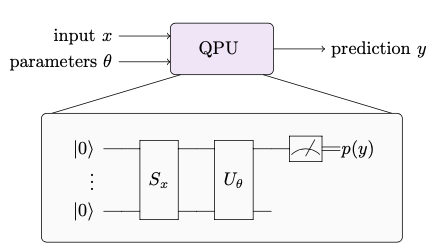

In the general case, a variational method is the approximation of an intractable function $f$ (for example solution of a PDE or an optimization problem) by a function $v$, more easily computable. The goal is then to find $v$ that will minimize a specific cost $\mathcal{L}(v)$. The cost function may be expensive to compute, which makes the problem difficult to solve. The idea of using Quantum Computing is to reduce the cost of estimation and in some cases gain an advantage on classical computers.

In our Machine Learning problem, let us suppose we observe $N$ samples of labeled data $(x_i, y_i)_{i \in [1,N]}$ with $x_i \in \mathbb{R}^2$ and $y_i \in \{0,1\}$. The goal of the task is to construct a predictor $f$ to estimate $y$ given a new value of $x$. The problem can be restricted to a set of parameterizable functions by a real vector $\theta$. We will train a model with the training input by finding the parameters $\theta$ that will minimize a loss $l$.

$$\arg\min_{\theta} \frac{1}{N} \sum_{i=1}^{N} l(f(x_i;\theta), y_i)$$

In our case, $f$ will return the probability of $x$ to be labelled $1$. It is then a number comprised between 0 and 1.
The authors use the square loss $l(f(x),y) = (f(x)-y)^2$, another usual loss is the binary crossentropy loss $l(f(x),y) = - y log(f(x)) - (1-y)log(1-f(x))$. In both cases, the farther $f(x)$ is from $y$, the greater the loss.

### The use of quantum computers

The idea of the proposed circuit is to compute $f(x;\theta)$ with a quantum computer, and then to optimize the cost with a classical optimization algorithm, with the hope that it will be more efficient than a full classical algorithm.

Quantum circuits are a very good framework to represent our problem, since the probability of a qubit to be in the state $|0\rangle$ or in the state $|1\rangle$ can be estimated by measurement. 

The circuit is composed of 3 steps and a postprocess step: 

- STEP 1. State preparation: encode the classical data $x$ into a quantum circuit buy creating an operator $\phi(x)$ which will result in the state $\phi(x) |0_p\rangle$ with $p$ the number of qubits.
- STEP 2.Model circuit: apply an operator $U(\theta)$ to the feature state, with $\theta$ the trainable parameters.
- STEP 3. Measurement: measure the qubit $q_0$ to estimate $f(x;\theta) = \mathbb{P}(q_0=1)$

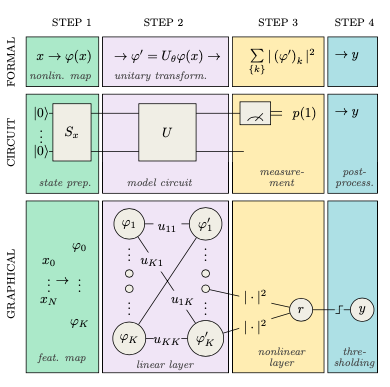

### State preparation

The classical data need to be converted into a quantum state. A quantum state is a unitary norm vector of complex numbers and can be written $|\psi \rangle = \sum_{i=1}^{n} a_i |i\rangle$ with $\sum_{i=1}^{n} |a_i|^2=1$, and $n=2^p$. Vectors with a power of 2 number of features can be normalized and represented into a quantum state using amplitude encoding, which means that the data are directly associated with the amplitudes of the quantum state. For other number of features, a strategy is to pad with the required number of features to reach a power of 2. The padding features can be zero on non-zero. It can be shown that the encoding can be done linearly with reference to the size of the input vector.

### Model circuit

Given the quantum state $|\phi(x) \rangle$ which represents the vector $x$ in the quantum circuit, we create $U(\theta)$ a unitary operator such that $U(\theta)|\phi(x) \rangle$ is a quantum state we can measure. 

We decompose $U(\theta) = U_1...U_L$ as a product of one or two qubits parametrized gates. In the following we will use a combination of C-NOT gates and general unitary gates whose general formulation is:
$$U(\theta, \phi, \lambda) = \begin{bmatrix}
  cos(\frac{\theta}{2}) & -e^{i\lambda}sin(\frac{\theta}{2})\\ 
  e^{i\phi}sin(\frac{\theta}{2}) & e^{i\lambda+i\phi}cos(\frac{\theta}{2})
\end{bmatrix} 
$$
This parameterization  is chosen because it is the one used by the language Qiskit. The authors of the paper choose another equivalent simpler parameterization, which doesn't need to compute imaginary parts (cf Training section).

### Measurement

The measurement of the 0 qubit of the quantum state $|U(\theta)\phi(x) \rangle$ generated by the previous circuit gives $f(x;\theta) = \mathbb{P}(y|x=1;\theta) = \mathbb{P}(q_0=1|x;\theta) = \sum_{k=1}^{n} |(U(\theta)\phi(x))_k|^2$. For clarity, the explicit dependency of $\theta$ will be removed and we will just note $U$ for $U(\theta)$

Let us denote $\pi(x;\theta) = \mathbb{P}(q_0=1|x;\theta)$. It can also be expressed by the expectancy of the operator $\sigma_z$ applied to the first qubit. $$\mathbb{E}(\sigma_z) = \langle \phi(x)|U^\dagger (\sigma_z \otimes \mathbb{I} \otimes ... \otimes \mathbb{I})U|\phi(x) \rangle$$ and $$\pi(x;\theta) = \frac{-\mathbb{E}(\sigma_z)}{2}+\frac{1}{2}$$.



### Training

The model is trained to minimize a loss function
$$\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} l(\pi(x_i;\theta), y_i)$$
The parameters are updated via batch stochastic gradient descent. The difficulty is to be able to compute the gradient in an accurate way. Fortunately, as later explained it is possible to evaluate the gradient via quantum circuits.

$$\nabla_\theta\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} \nabla_\theta(l(\pi(x_i;\theta), y_i)) = 
\frac{1}{N} \sum_{i=1}^{N} \nabla_\theta\pi(x_i;\theta)\partial_1l(\pi(x_i;\theta), y_i)$$ where $\partial_1l$ is the partial derivative of $l$ with reference to the first variable.

$$\nabla_\theta\pi(x_i;\theta) = \frac{-\nabla_\theta\mathbb{E}(\sigma_z)}{2} = -\frac{1}{2} \nabla_\theta\langle \phi(x)U | \sigma_z |U\phi(x) \rangle$$ where $\sigma_z \otimes \mathbb{I} \otimes ... \otimes \mathbb{I}$ is abbreviated to $\sigma_z$.

Let us now consider $\nu$ an element of the vector $\theta$ and let us examine $\partial_\nu \pi(x;\theta)$

$$\partial_\nu\pi(x;\theta) = -\frac{1}{2} \langle \phi(x)\partial_\nu U| \sigma_z |U\phi(x) \rangle -\frac{1}{2} \langle \phi(x)U |\sigma_z |\partial_\nu U\phi(x) \rangle $$ by the rules of derivation inside an expectation. 

$$\partial_\nu\pi(x;\theta) = -\frac{1}{2} (\langle \phi(x)\partial_\nu U| \sigma_z |U\phi(x) \rangle + \langle \phi(x)\partial_\nu U| \sigma_z |U\phi(x) \rangle^*) = - Re\{ \langle \phi(x)\partial_\nu U| \sigma_z |U\phi(x) \rangle\}$$

Generally speaking, $\partial_\nu U$ is not a unitary operator, and therefore cannot be implemented in a quantum circuit. However, due to our circuit architecture, il will be possible.

The derivative of $U$ w.r.t $\nu$ involves only the derivative of the elementary gate to which $\nu$ belongs, due to the factorization of the circuit. It means that $\partial_\nu U = U_1...\partial_\nu(U_i)...U_L$ where $U_i$ is the gate to which $\nu$ belongs.

For an elementary unitary gate as described above, we have the following identities:

$$\partial_\theta U = \frac{1}{2} U(\theta + \pi, \phi, \lambda)$$

$$\partial_\phi U = \frac{i}{2} (U(\theta, \phi, \lambda) - U(\theta, \phi + \pi, \lambda))$$

$$\partial_\lambda U = \frac{i}{2} U(\theta, \phi, \lambda) - U(\theta, \phi, \lambda + \pi))$$

Therefore $\partial_\nu U$ can be computed as the form

$$ \sum_{k=1}^{K}a_k Re\{ \langle \phi(x)U(\theta^{[k]})| \sigma_z |U(\theta)\phi(x) \rangle\}+ \sum_{l=1}^{L}b_l Im\{ \langle \phi(x)U(\theta^{[l]})| \sigma_z |U(\theta)\phi(x) \rangle\}$$ where $\theta^{[k]}$ and $\theta^{[l]}$ are the modified vector of parameters from the above identities. The imaginary part comes from the $i$ in the same identities for $\phi$ and $\lambda$.

## Implementation

### Importing and cleaning the data, state preparation

We use as an example this dataset. This dataset is composed of several variables. We want to only needna 2 feature columns dataset, so we reduce dimensions with for example a PCA analysis. The data are then padded with constant values and renormalized to have a unitary vector. We use a special routine to encode the data in the quantum circuit. 

#### Important: I suggest to use quantum algorithms in a separate environment dedicated only to quantum computing.

In [1]:
# MatplotlibDrawer needs pylatexenc. You need to install it:
#pip install pylatexenc

In [3]:
import numpy as np
import seaborn as sns
from qiskit import *
from qiskit.tools.jupyter import *
import matplotlib.pyplot as plt
import pylatexenc
from scipy.optimize import minimize
from sklearn.preprocessing import Normalizer, normalize, binarize, Binarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA, LatentDirichletAllocation
import pandas as pd
import gc as gc
backend = BasicAer.get_backend('qasm_simulator') # for using a quantum simulator

To run the experiment on a real quantum computer, you need to setup your account first.

In [4]:
#Using other quantum processors from IBM
#from qiskit import IBMQ
#IBMQ.save_account('c42be77bc7bcc969263dd866c03b2a05fefd1d203ae6aedc6765543cae8ac3d862c8fcdff5aca2f486c0ba36f764393e76718d54bc679c1aeeec78ff32bab7dd')
#provider = IBMQ.load_account()
# You can check in IBM site the cues in different backend processors. 
# You can choose processors with lower cues to speed up your work. 
#backend = provider.backends.ibmq_london 

In [5]:
#from qiskit.tools.monitor import job_monitor
#shots = 1024        
#max_credits = 3   
#job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
#job_monitor(job_exp)

In [6]:
gc.collect()

123

In [7]:
data = pd.read_csv("General.csv")
data = data.drop(columns=['Unnamed: 0', 
                          'reconocimiento medico', 'seguro medico', 'revision medica', 
                          'cobertura medica' , 'fecha', 'BlobText_seguro'])

In [8]:
# Removing outliers for a better accuracy. As alterntive you can apply a 
# RobustScaler algortihm. 
Q1 = data.quantile(0.1)
Q3 = data.quantile(0.9)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]

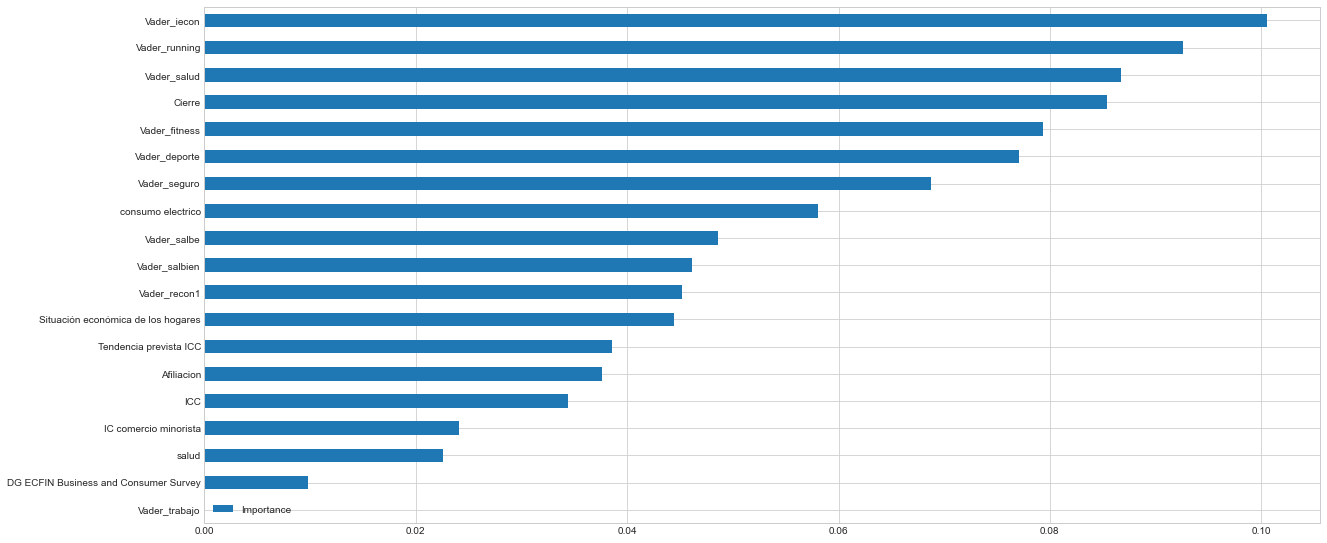

In [9]:
# Using Random Forest to gain insights on Feature Importance
data['Vader_gimnasio'] =(data['Vader_gimnasio'] > -0.050).astype(int)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
clf = RandomForestClassifier()
clf.fit(data.drop(columns='Vader_gimnasio'),data.Vader_gimnasio)

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=data.drop(columns='Vader_gimnasio').columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

In [10]:
importance.sort_values(by='Importance', ascending=False) > 0.07

,Importance
Vader_iecon,True
Vader_running,True
Vader_salud,True
Cierre,True
Vader_fitness,True
Vader_deporte,True
Vader_seguro,False
consumo electrico,False
Vader_salbe,False
Vader_salbien,False


In [11]:
class_labels = ['Interés bajo', 'Interés alto']
# We choose only the relevant features and remove the rest
X = data.drop(columns=['Vader_gimnasio', 'salud', 'Vader_trabajo', 'Vader_salbe', 'Vader_salbien',
                      'Afiliacion', 'consumo electrico', 'ICC', 'Tendencia prevista ICC', 'Vader_seguro',
                       'Situación económica de los hogares', 'DG ECFIN Business and Consumer Survey', 'Vader_recon1'])
Y = data.Vader_gimnasio
Y = np.array(Y)

In [12]:
#scale value from 0 to 1 (so we remove negative values)
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)

In [13]:
n_dim = 2
# I use linear Kernel PCA to reduce the number of dimensions of the dataset to n_dim = 2
pca = KernelPCA(n_components=n_dim).fit(X)
X = pca.transform(X)
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)

Quantum algorithms that are only polynomial in the number n of qubits can perform computations on $2n$ amplitudes. If these 2n amplitudes are used to encode the data, one can therefore process data inputs in polylogarithmic time.
Given a unitary vector of dimension 4 ( $2^2$, as we use 2  qbits in this example ), we extract 5 angles with the function `get_angles`. These angles will serve as arguments to the encoding quantum circuit.

In [14]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1]) ** 2 / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3]) ** 2 / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [15]:
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])


First X sample (original)  : [0.23503585 0.65878131]
First X sample (padded)    : [0.23503585 0.65878131 0.3        0.        ]
First X sample (normalized): [0.30882101 0.86559352 0.39417945 0.        ]
First features sample      : [ 0.81034968 -0.          0.         -1.22809981  1.22809981]


### STEP 1. State preparation 

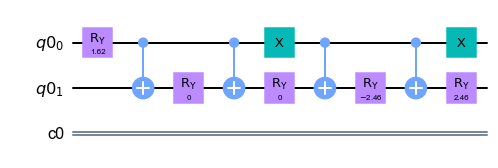

In [16]:
def statepreparation(a, circuit, target):
    
    a = 2*a
    circuit.ry(a[0], target[0])
    
    circuit.cx(target[0], target[1])
    circuit.ry(a[1], target[1])
    circuit.cx(target[0], target[1])
    circuit.ry(a[2], target[1])

    circuit.x(target[0])
    circuit.cx(target[0], target[1])
    circuit.ry(a[3], target[1])
    circuit.cx(target[0], target[1])
    circuit.ry(a[4], target[1])
    circuit.x(target[0])
    
    return circuit

x = X_norm[0]
ang = get_angles(x)
q       = QuantumRegister(2)
c       = ClassicalRegister(1)
circuit = QuantumCircuit(q,c)
circuit = statepreparation(ang, circuit, [0,1])
circuit.draw(output='mpl')

### STEP 2. Model circuit

These are intermediary functions that will help us to build our circuit. The ciruit is composed of several stacked blocks, which we can call layers, to make an analogy with neural networks. A layer is composed of a general parameterized unitary gate applied to both qubits, and 

In [17]:
def u_gate(param, circuit, target):
    '''Return the quantum circuit with u3 gate applied on qubit target with param as an iterable'''
    circuit.u3(param[0],param[1],param[2],target)
    return circuit

def cu_gate(param, circuit, control, target):
    '''Return the quantum circuit with cu3 gate applied on qubit target with param as an iterable wrt control'''
    circuit.cu3(param[0],param[1],param[2], control, target)
    return circuit

def circuit_block(param, circuit, target, same_order_x=True):
    '''Return the block applied on qubits target from the circuit circuit
    - param : array parameters for the two u gate
    - target : array of integer the numero of qubits for the u gates to be applied
    - if same_order_x == True : cx(target[0], target[1])
    else: cx(target[1], target[0])'''
    circuit = u_gate(param[0], circuit, target[0])
    circuit = u_gate(param[1], circuit, target[1])
    if same_order_x:
        circuit.cx(target[0], target[1])
    else:
        circuit.cx(target[1], target[0])
    return circuit

def c_circuit_block(param, circuit, control, target, same_order_x=True):
    '''Return the controlled block applied on qubits target from the circuit circuit
    - param : array parameters for the two u gate
    - target : array of integer the numero of qubits for the u gates to be applied
    - if same_order_x == True : cx(target[0], target[1])
    else: cx(target[1], target[0])'''
    circuit = cu_gate(param[0], circuit, control, target[0])
    circuit = cu_gate(param[1], circuit, control, target[1])
    if same_order_x:
        circuit.ccx(control, target[0], target[1])
    else:
        circuit.ccx(control, target[1], target[0])
    return circuit

def create_circuit(param, circuit, target):
    order = True
    for i in range(param.shape[0]):
        circuit = circuit_block(param[i], circuit, target, order)
        order = not order
    return circuit

def create_c_circuit(param, circuit, control, target):
    order = True
    for i in range(param.shape[0]):
        circuit = c_circuit_block(param[i], circuit, control, target, order)
        order = not order 
    return circuit

The final circuit including state preparation, model and measurement is implemented below.

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  This is separate from the ipykernel package so we can avoid doing imports until


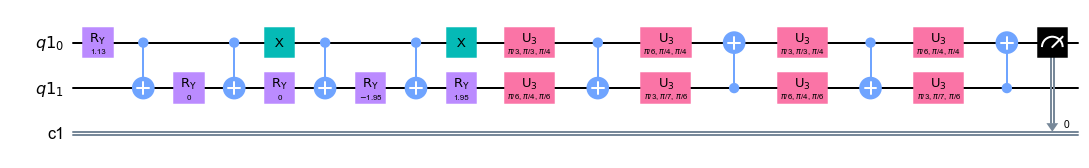

In [18]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0])
ang = get_angles(x)

params = np.array([[[np.pi/3,np.pi/3,np.pi/4],
                    [np.pi/6,np.pi/4,np.pi/6]],
                    [[np.pi/6,np.pi/4,np.pi/4],
                    [np.pi/3,np.pi/7,np.pi/6]],
                    [[np.pi/3,np.pi/3,np.pi/4],
                    [np.pi/6,np.pi/4,np.pi/6]],
                    [[np.pi/6,np.pi/4,np.pi/4],
                    [np.pi/3,np.pi/7,np.pi/6]]])

q       = QuantumRegister(2)
c       = ClassicalRegister(1)
circuit = QuantumCircuit(q,c)
circuit = statepreparation(ang, circuit, [0,1])

circuit = create_circuit(params, circuit, [0,1])

circuit.measure(0,c)

circuit.draw(output='mpl')

The following function executes the circuit and returns the result of measurements.

In [19]:
def execute_circuit(params, angles=None, x=None, use_angles=True, bias=0, shots=1000):
    if not use_angles:
        angles = get_angles(x)
    q       = QuantumRegister(2)
    c       = ClassicalRegister(1)
    circuit = QuantumCircuit(q,c)
    circuit = statepreparation(angles, circuit, [0,1])

    circuit = create_circuit(params, circuit, [0,1])
    circuit.measure(0,c)
    result = execute(circuit,backend,shots=shots).result()

    counts = result.get_counts(circuit)
    result=np.zeros(2)
    for key in counts:
        result[int(key,2)]=counts[key]
    result/=shots
    return result[1] + bias

execute_circuit(params, ang, bias=0.02)

0.128

### Cost and accuracy functions

We define now the cost function, square loss, binary crossentropy and accuracy.

In [20]:
def predict(probas):
    return (probas>=0.5)*1

def binary_crossentropy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss - l * np.log(np.max([p,1e-8]))

    loss = loss / len(labels)
    return loss

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss 

def cost(params, features, labels):
    predictions = [execute_circuit(params, angles=f) for f in features]
    return binary_crossentropy(labels, predictions)

In [21]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

### Computing the gradients

The following routines will compute $Re\{ \langle \phi(x)U(\theta^{[k]})| \sigma_z |U(\theta)\phi(x) \rangle\}$ and $Im\{ \langle \phi(x)U(\theta^{[l]})| \sigma_z |U(\theta)\phi(x) \rangle\}$ for given parameters $\theta^{[k]}$, $\theta^{[l]}$ and $\theta$.

Let us assume we can prepare two unitary states $|A\rangle$ and $|B\rangle$ (result of an action of unitary operators $A$ and $B$ on $|0_p\rangle$) conditioned to the state of an ancilla qubit $a$, that is the state 
$$ \frac{|0\rangle|A\rangle + |1\rangle|B\rangle}{\sqrt{2}}$$

Applying a Hadamard to the ancilla leads to 
$$ \frac{|0\rangle(|A\rangle+|B\rangle) + |1\rangle(|A\rangle-|B\rangle)}{2}$$

$\mathbb{P}(a=0) = (|A\rangle+|B\rangle)^\dagger(|A\rangle+|B\rangle) = \frac{1}{4}(2 + \langle A|B\rangle + \langle B|A\rangle) = \frac{1}{2} + \frac{1}{2}Re(\langle A|B\rangle)$. By measuring the ancilla, it is then possible to obtain $Re(\langle A|B\rangle)$.

To compute $Im(\langle A|B\rangle)$, the procedure is very similar. We prepare the state 
$$ \frac{|0\rangle|A\rangle + i|1\rangle|B\rangle}{\sqrt{2}}$$
This can be done by applying a $U(0,0,\pi/2)$ gate to the ancilla. We then apply a Hadamard to the ancilla, and we have $\mathbb{P}(a=0) = \frac{1}{2} - \frac{1}{2}Im(\langle A|B\rangle)$

**How to prepare the initial conditioned state?**

We start with $p$ qubits and an ancilla, and apply a Hadamard gate to the ancilla. It leads to the state
$$\frac{|0\rangle|0_p\rangle + |1\rangle|0_p\rangle}{\sqrt{2}}$$

We apply $B$ controlled by the ancilla to the $p$ qubits, which is
$$\frac{|0\rangle|0_p\rangle + |1\rangle|B\rangle}{\sqrt{2}}$$

We flip the ancilla
$$\frac{|1\rangle|0_p\rangle + |0\rangle|B\rangle}{\sqrt{2}}$$

We apply $A$ controlled by the ancilla to the $p$ qubits
$$\frac{|1\rangle|A\rangle + |0\rangle|B\rangle}{\sqrt{2}}$$

We flip again the ancilla
$$\frac{|0\rangle|A\rangle + |1\rangle|B\rangle}{\sqrt{2}}$$

In [22]:
def real(param1, param2, angles, shots=1000):
    """Returns Re{<circuit(param2)|sigma_z|circuit(param1)>}"""
    q = QuantumRegister(3)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q,c)
    circuit.h(q[0])
    circuit = statepreparation(angles, circuit, [1,2])
    circuit = create_c_circuit(param1, circuit, 0, [1,2])
    circuit.cz(q[0], q[1])
    circuit.x(q[0])
    circuit = create_c_circuit(param2, circuit, 0, [1,2])
    circuit.x(q[0])
    circuit.h(q[0])
    circuit.measure(q[0],c)
    result = execute(circuit,backend,shots=shots).result()
    counts = result.get_counts(circuit)
    result=np.zeros(2)
    for key in counts:
        result[int(key,2)]=counts[key]
    result/=shots
    return (2*result[0]-1)

def imaginary(param1, param2, angles, shots=1000):
    """Returns Im{<circuit(param2)|sigma_z|circuit(param1)>}"""
    q = QuantumRegister(3)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q,c)
    circuit.h(q[0])
    circuit = statepreparation(angles, circuit, [1,2])
    circuit = create_c_circuit(param1, circuit, 0, [1,2])
    circuit.cz(q[0], q[1])
    circuit.x(q[0])
    circuit = create_c_circuit(param2, circuit, 0, [1,2])
    circuit.x(q[0])
    circuit.u1(np.pi/2, q[0])
    circuit.h(q[0])
    circuit.measure(q[0],c)
    result = execute(circuit,backend,shots=shots).result()
    counts = result.get_counts(circuit)
    result=np.zeros(2)
    for key in counts:
        result[int(key,2)]=counts[key]
    result/=shots
    return -(2*result[0]-1)

In [23]:
def gradients(params, angles, label, bias=0):
    grads = np.zeros_like(params)
    imag = imaginary(params, params, angles)
    for i in range(params.shape[0]):
        for j in range(params.shape[1]):
            params_bis = np.copy(params)
            
            params_bis[i,j,0]+=np.pi
            grads[i,j,0] = -0.5 * real(params, params_bis, angles)
            params_bis[i,j,0]-=np.pi
            
            params_bis[i,j,1]+=np.pi
            grads[i,j,1] = 0.5 * (imaginary(params, params_bis, angles) - imag)
            params_bis[i,j,1]-=np.pi
            
            params_bis[i,j,2]+=np.pi
            grads[i,j,2] = 0.5 * (imaginary(params, params_bis, angles) - imag)
            params_bis[i,j,2]-=np.pi
    p = execute_circuit(params, angles, bias=bias) 
    grad_bias = (p - label) / (p * (1 - p))
    grads *= grad_bias
    return grads, grad_bias
            

### STEP 3. Measurement 

### Training the model

In [24]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [25]:
layers = 6
params_init = np.random.randn(layers,2,3) * 0.01
bias_init = 0.01
batch_size = 5
learning_rate = 0.01
momentum = 0.9

var = np.copy(params_init)
bias = bias_init
v = np.zeros_like(var)
v_bias = 0

for it in range(15):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    grads = np.zeros_like(var)
    grad_bias = 0
    var_corrected = var + momentum * v
    bias_corrected = bias + momentum * v_bias
    for j in range(batch_size):
        g, g_bias = gradients(var_corrected, feats_train_batch[j], Y_train_batch[j], bias)
        grads += g / batch_size
        grad_bias +=g_bias / batch_size
    
    v = momentum * v - learning_rate * grads
    v_bias = momentum * v_bias - learning_rate * grad_bias
    
    var += v
    bias += v_bias

    # Compute predictions on train and validation set
    probas_train = np.array([execute_circuit(var, angles=f, bias=bias) for f in feats_train])
    probas_val = np.array([execute_circuit(var, angles=f, bias=bias) for f in feats_val])
    predictions_train = predict(probas_train)
    predictions_val = predict(probas_val)

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Loss: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
    )

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.


Iter:     1 | Loss: 0.3100236 | Acc train: 0.6757576 | Acc validation: 0.6396396 
Iter:     2 | Loss: 0.3080325 | Acc train: 0.6878788 | Acc validation: 0.6486486 
Iter:     3 | Loss: 0.2932128 | Acc train: 0.7000000 | Acc validation: 0.6486486 
Iter:     4 | Loss: 0.2921732 | Acc train: 0.7090909 | Acc validation: 0.6396396 
Iter:     5 | Loss: 0.2835880 | Acc train: 0.7151515 | Acc validation: 0.6306306 
Iter:     6 | Loss: 0.2752897 | Acc train: 0.7303030 | Acc validation: 0.6306306 
Iter:     7 | Loss: 0.2720776 | Acc train: 0.7272727 | Acc validation: 0.6306306 
Iter:     8 | Loss: 0.2694250 | Acc train: 0.7303030 | Acc validation: 0.6306306 
Iter:     9 | Loss: 0.2722688 | Acc train: 0.7303030 | Acc validation: 0.6306306 
Iter:    10 | Loss: 0.2658310 | Acc train: 0.7303030 | Acc validation: 0.6486486 
Iter:    11 | Loss: 0.2646052 | Acc train: 0.7303030 | Acc validation: 0.6486486 
Iter:    12 | Loss: 0.2546762 | Acc train: 0.7333333 | Acc validation: 0.6486486 
Iter:    13 | Lo

In [26]:
gc.collect()

6243

### Plot results

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.


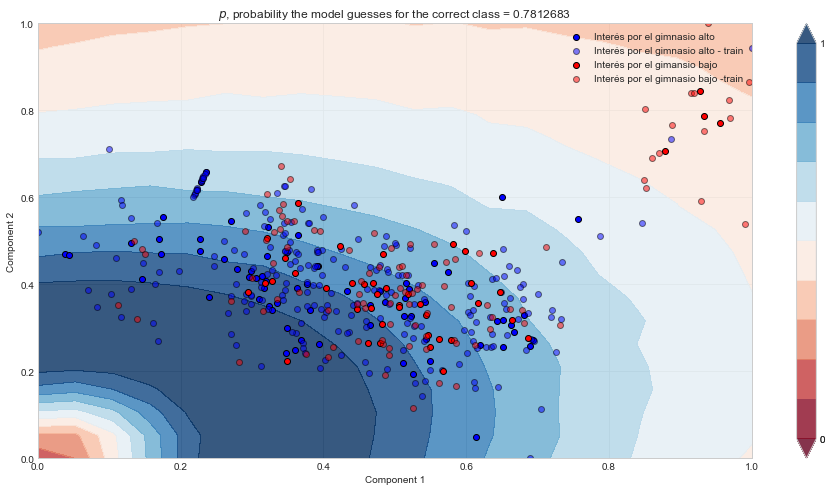

In [27]:
plt.figure(figsize=(16,8))

cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1, 20), np.linspace(0.0, 1, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  


# angles for state preparation are new features
predictions_grid = [execute_circuit(var, angles=f, bias=bias, shots=10000) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[0, 0, 1])

# plot data

ce = cost(var, features, Y)
plt.title("$p$, probability the model guesses for the correct class = {:0.7f}"
         "".format(np.e**(-ce)))

plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="Interés por el gimnasio alto",
)

plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    alpha=0.5,
    label="Interés por el gimnasio alto - train",
)


plt.scatter(
    X_val[:, 0][Y_val == 0],
    X_val[:, 1][Y_val == 0],
    c="r",
    marker="o",
    edgecolors="k",
    label="Interés por el gimansio bajo ",
)

plt.scatter(
    X_train[:, 0][Y_train == 0],
    X_train[:, 1][Y_train == 0],
    c="r",
    marker="o",
    edgecolors="k",
    alpha=0.5,
    label="Interés por el gimnasio bajo -train",
)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.savefig('/Users/javiermarin/desktop/Grafica4-o.png')
plt.show()

# Cross-entropy loss and probability

We use binary cross-entropy loss as a $loss function$ for this two classes classification problem.

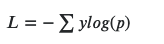

where 𝑦 is the binary class label, 1 if the correct class 0 otherwise, and 𝑝 is the probability of each class. 

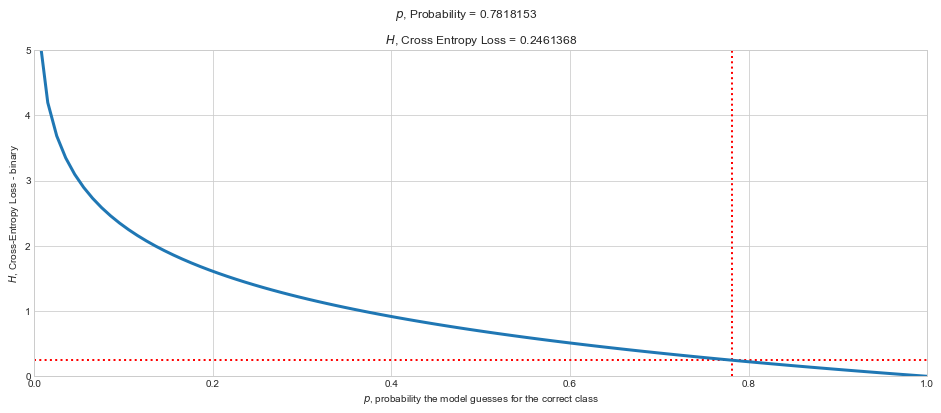

In [28]:
plt.figure(figsize=(16,6))
# Binnary cross-entropy loss
def cross_entropy(p):
    return -np.log(p)
ps = np.linspace(0.005, 1, 100)
ces = [cross_entropy(p) for p in ps]
ce = cost(var, features, Y)


plt.plot(ps, ces, lw=3)
plt.title("$H$, Cross Entropy Loss = {:0.7f}"
         "".format(ce))
plt.suptitle("$p$, Probability = {:0.7f}"
         "".format(np.e**(-ce)))
plt.ylabel('$H$, Cross-Entropy Loss - binary')
plt.xlabel('$p$, probability the model guesses for the correct class')
plt.hlines((cost(var, features, Y)), 0, 1, colors='red', lw=2, linestyles='dotted')
plt.vlines(np.e**(-ce), 0, 5, colors='red', lw=2, linestyles='dotted')
plt.xlim(0,1)
plt.ylim(0,5)
plt.show()